# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

acc_drop = metadata[metadata["genotype"] == "rpoC G17D"]["Run"].tolist()
acc_drop = [acc + "_sorted.bam" for acc in acc_drop]
df_initial.drop(columns=acc_drop, inplace=True)
metadata = metadata[metadata['genotype'] == 'WT']

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR27597800_sorted.bam,SRR27597810_sorted.bam,SRR27597822_sorted.bam,SRR27597792_sorted.bam,SRR27597794_sorted.bam,...,SRR27597805_sorted.bam,SRR27597797_sorted.bam,SRR27597795_sorted.bam,SRR27597796_sorted.bam,SRR27597793_sorted.bam,SRR27597814_sorted.bam,SRR27597811_sorted.bam,SRR27597808_sorted.bam,SRR27597798_sorted.bam,SRR27597803_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
gene-NRS_9,CP027476.1,544,1905,+,1362,2438,12539,12999,1343,1203,...,11489,3919,2072,1745,1941,16052,15038,13943,2816,8662
gene-NRS_10,CP027476.1,2183,3316,+,1134,3211,14176,15604,1775,1531,...,14300,5148,2734,2270,2647,18837,17662,16301,3215,10798
gene-NRS_11,CP027476.1,3697,3942,+,246,902,3968,4534,477,489,...,4311,1386,695,716,593,5142,4780,4493,914,3086
gene-NRS_12,CP027476.1,3939,5051,+,1113,3496,16699,18275,1891,1694,...,16690,5502,2719,2382,2472,22245,20244,19364,3525,12668
gene-NRS_13,CP027476.1,5061,6995,+,1935,4665,26314,34068,2945,3984,...,31774,8698,3911,4487,4074,39594,33335,33438,5551,20311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-CPT_phageK_gp037,NC_005880.2,146607,146843,+,237,3022,12769,2998,1965,2240,...,15661,5345,2839,2366,2690,4680,13719,19759,4018,10693
gene-CPT_phageK_gp036,NC_005880.2,146923,147393,+,471,1994,7110,1343,1838,2792,...,8225,4720,2447,2618,2544,2244,6954,9728,3660,5768
gene-CPT_phageK_gp035,NC_005880.2,147452,147625,+,174,1145,3378,490,1358,1886,...,3234,3002,1619,1737,1711,739,2919,4824,2660,2797


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time_point,treatment
22,SRR27597789,RNA-Seq,202,5343421362,PRJNA1065939,SAMN39476148,1754044130,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266283,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022462,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:01:00Z,1,GSM8022462,NRS384,SRP484313,40 min,infected with phage K
23,SRR27597790,RNA-Seq,202,5733357314,PRJNA1065939,SAMN39476149,1900044137,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266282,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022461,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022461,NRS384,SRP484313,40 min,infected with phage K
24,SRR27597791,RNA-Seq,202,5206661302,PRJNA1065939,SAMN39476150,1710699886,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266281,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022460,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022460,NRS384,SRP484313,40 min,infected with phage K
25,SRR27597792,RNA-Seq,202,5699761078,PRJNA1065939,SAMN39476151,1891773540,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266280,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022459,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022459,NRS384,SRP484313,40 min,infected with phage K
26,SRR27597793,RNA-Seq,202,5283060126,PRJNA1065939,SAMN39476152,1750753120,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266279,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022458,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022458,NRS384,SRP484313,30 min,infected with phage K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,SRR27597812,RNA-Seq,202,5463391990,PRJNA1065939,SAMN39476171,1801709649,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266260,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022439,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:01:00Z,1,GSM8022439,NRS384,SRP484313,02 min,infected with phage K
46,SRR27597813,RNA-Seq,202,5681921044,PRJNA1065939,SAMN39476172,1888173324,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266259,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022438,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:04:00Z,1,GSM8022438,NRS384,SRP484313,0 min,infected with phage K
47,SRR27597814,RNA-Seq,202,6597329696,PRJNA1065939,SAMN39476173,2217684693,NRS384,bacterial cells,LABO

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM8022435': '0_R1',  'GSM8022436': '0_R2',  'GSM8022437': '0_R3', 'GSM8022438': '0_R4',
              'GSM8022439': '2_R1',  'GSM8022440': '2_R2',  'GSM8022441': '2_R3', 'GSM8022442': '2_R4',
              'GSM8022443': '5_R1',  'GSM8022444': '5_R2',  'GSM8022445': '5_R3', 'GSM8022446': '5_R4',
              'GSM8022447': '10_R1',  'GSM8022448': '10_R2',  'GSM8022449': '10_R3', 'GSM8022450': '10_R4',
              'GSM8022451': '20_R1',  'GSM8022452': '20_R2',  'GSM8022453': '20_R3', 'GSM8022454': '20_R4',
              'GSM8022455': '30_R1',  'GSM8022456': '30_R2',  'GSM8022457': '30_R3', 'GSM8022458': '30_R4',
              'GSM8022459': '40_R1',  'GSM8022460': '40_R2',  'GSM8022461': '40_R3', 'GSM8022462': '40_R4'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time_point,treatment
22,SRR27597789,RNA-Seq,202,5343421362,PRJNA1065939,SAMN39476148,1754044130,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266283,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022462,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:01:00Z,1,GSM8022462,NRS384,SRP484313,40 min,infected with phage K


In [9]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time_point,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR27597789_sorted.bam,SRR27597789,RNA-Seq,202,5343421362,PRJNA1065939,SAMN39476148,1754044130,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266283,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022462,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:01:00Z,1,GSM8022462,NRS384,SRP484313,40 min,infected with phage K,SRR27597789_sorted.bam,40_R4
SRR27597790_sorted.bam,SRR27597790,RNA-Seq,202,5733357314,PRJNA1065939,SAMN39476149,1900044137,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266282,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022461,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022461,NRS384,SRP484313,40 min,infected with phage K,SRR27597790_sorted.bam,40_R3
SRR27597791_sorted.bam,SRR27597791,RNA-Seq,202,5206661302,PRJNA1065939,SAMN39476150,1710699886,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266281,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022460,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022460,NRS384,SRP484313,40 min,infected with phage K,SRR27597791_sorted.bam,40_R2
SRR27597792_sorted.bam,SRR27597792,RNA-Seq,202,5699761078,PRJNA1065939,SAMN39476151,1891773540,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266280,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022459,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022459,NRS384,SRP484313,40 min,infected with phage K,SRR27597792_sorted.bam,40_R1
SRR27597793_sorted.bam,SRR27597793,RNA-Seq,202,5283060126,PRJNA1065939,SAMN39476152,1750753120,NRS384,bacterial cells,LABORATORY OF MUCOSAL PATHOGENS AND CELLULAR I...,missing,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX23266279,WT,uncalculated,uncalculated,missing,Illumina NovaSeq 6000,GSM8022458,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus aureus,ILLUMINA,2024-10-10T00:00:00Z,2024-01-17T20:00:00Z,1,GSM8022458,NRS384,SRP484313,30 min,infected with phage K,SRR27597793_sorted.bam,30_R4


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '0_R3', '0_R4',
         '2_R1', '2_R2', '2_R3', '2_R4',
         '5_R1', '5_R2', '5_R3', '5_R4',
         '10_R1', '10_R2', '10_R3', '10_R4',
         '20_R1', '20_R2', '20_R3', '20_R4',
         '30_R1', '30_R2', '30_R3', '30_R4',
         '40_R1', '40_R2', '40_R3', '40_R4']]
df.head()

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_9,12999,12539,16052,13867,12308,15038,12539,10892,13943,9929,7581,11489,7236,8662,7059,5463,2438,3214,2816,3919,1745,2072,1203,1941,1343,1475,1392,1831
gene-NRS_10,15604,15101,18837,16267,14222,17662,14176,12641,16301,11684,7761,14300,8408,10798,8365,7216,3211,4085,3215,5148,2270,2734,1531,2647,1775,1782,1794,2161
gene-NRS_11,4534,4721,5142,4350,4015,4780,3968,3266,4493,3372,3433,4311,2313,3086,2256,2307,902,1245,914,1386,716,695,489,593,477,624,495,582
gene-NRS_12,18275,17916,22245,19178,17386,20244,16699,15184,19364,13971,9959,16690,10135,12668,9858,8510,3496,4470,3525,5502,2382,2719,1694,2472,1891,2095,1956,2261
gene-NRS_13,34068,39769,39594,35230,33285,33335,26314,25556,33438,23874,28139,31774,17679,20311,16277,13441,4665,7329,5551,8698,4487,3911,3984,4074,2945,3199,3075,3880


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_005880.2_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_005880.2"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
2629,NC_005880.2,RefSeq,gene,486.0,785.0,.,+,.,gene-CPT_phageK_gp001,CPT_phageK_gp001,Gene,protein_coding,CPT_phageK_gp001,gene-CPT_phageK_gp001,hypothetical protein,hypothetical protein,654.0,unknown function
2630,NC_005880.2,RefSeq,gene,801.0,986.0,.,+,.,gene-CPT_phageK_gp002,CPT_phageK_gp002,Gene,protein_coding,CPT_phageK_gp002,gene-CPT_phageK_gp002,hypothetical protein,hypothetical protein,3204.0,unknown function
2631,NC_005880.2,RefSeq,gene,1093.0,1380.0,.,+,.,gene-CPT_phageK_gp003,CPT_phageK_gp003,Gene,protein_coding,CPT_phageK_gp003,gene-CPT_phageK_gp003,hypothetical protein,hypothetical protein,654.0,unknown function
2632,NC_005880.2,RefSeq,gene,1380.0,1706.0,.,+,.,gene-CPT_phageK_gp004,CPT_phageK_gp004,Gene,protein_coding,CPT_phageK_gp004,gene-CPT_phageK_gp004,hypothetical protein,hypothetical protein,654.0,unknown function
2633,NC_005880.2,RefSeq,gene,1722.0,2015.0,.,+,.,gene-CPT_phageK_gp005,CPT_phageK_gp005,Gene,protein_coding,CPT_phageK_gp005,gene-CPT_phageK_gp005,hypothetical protein,hypothetical protein,654.0,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2861,NC_005880.2,RefSeq,gene,146607.0,146843.0,.,+,.,gene-CPT_phageK_gp037,CPT_phageK_gp037,Gene,protein_coding,CPT_phageK_gp037,gene-CPT_phageK_gp037,hypothetical protein,hypothetical protein,3480.0,unknown function
2862,NC_005880.2,RefSeq,gene,146923.0,147393.0,.,+,.,gene-CPT_phageK_gp036,CPT_phageK_gp036,Gene,protein_coding,CPT_phageK_gp036,gene-CPT_phageK_gp036,hypothetical protein,hypothetical protein,2543.0,unknown function
2863,NC_005880.2,RefSeq,gene,147452.0,147625.0,.,+,.,gene-CPT_phageK_gp035,CPT_phageK_gp035,Gene,protein_coding,CPT_phageK_gp035,gene-CPT_phageK_gp035,hypothetical protein,hypothetical protein,3789.0,unknown function
2864,NC_005880.2,RefSeq,gene,147625.0,147894.0,.,+,.,gene-CPT_phageK_gp034,CPT_phageK_gp034,Gene,protein_coding,CPT_phageK_gp034,gene-CPT_phageK_gp034,hypothetical protein,hypothetical protein,3549.0,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'CP027476.1', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_1012,43054,47775,53168,44422,38920,47773,35104,33907,51712,37112,26469,48763,24807,33222,25634,19356,9320,9146,8872,12270,7274,7205,6865,7106,5375,5823,5253,6208
gene-NRS_44,287,260,412,365,408,383,389,315,358,261,244,225,266,199,191,166,51,119,89,127,45,57,23,51,51,38,40,66
gene-NRS_2528,1334,1285,1390,1279,1159,1344,997,892,1392,863,737,1228,678,881,653,584,271,285,245,351,231,264,197,252,212,182,195,213
gene-NRS_436,11378,14450,13290,10573,9133,11121,7505,8736,13001,9450,10911,14696,6223,8522,5636,4886,1951,2180,1921,2992,2316,1755,2133,1601,1290,1278,1416,1218
gene-NRS_219,610,590,734,624,598,697,513,438,710,510,405,610,369,443,360,300,117,132,111,190,61,64,63,71,61,48,70,58


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_1012,486.550933,510.748168,501.902000,492.013131,421.050474,491.978932,449.012735,473.908607,413.627041,437.105997,268.864940,474.064199,274.314713,355.350444,302.799985,349.051573,211.083137,161.089447,168.830703,188.264527,134.279561,142.103873,155.386553,145.722480,110.118751,128.201733,103.142846,129.075692,host,gene-NRS_1012
gene-NRS_44,3.648661,3.127485,4.372949,4.546184,4.962879,4.435174,5.594860,4.952039,3.220242,3.458790,2.789030,2.461925,3.309400,2.396367,2.540304,3.371808,1.309807,2.363556,1.912557,2.196860,0.943201,1.273490,0.597303,1.185943,1.184774,0.951824,0.892959,1.552621,host,gene-NRS_44
gene-NRS_2528,10.371580,9.451272,9.027180,9.746094,8.626668,9.522190,8.774560,8.578743,7.659937,6.994320,5.151896,8.213609,5.159796,6.484305,5.308761,7.248763,4.228640,3.458079,3.212725,3.708926,2.938829,3.587435,3.074149,3.560810,2.993767,2.763053,2.639695,3.052617,host,gene-NRS_2528
gene-NRS_436,147.030017,176.642696,143.455456,133.907129,112.980688,130.958606,109.770775,139.619970,118.909919,127.271913,126.731369,163.368169,78.688638,104.232414,76.129283,100.756229,50.535215,43.911622,41.807774,52.499072,48.893407,39.587115,55.213483,37.549916,30.228156,32.182648,31.799346,28.966401,host,gene-NRS_436
gene-NRS_219,9.209711,8.426982,9.255649,9.233295,8.643119,9.588579,8.767724,8.181237,7.586266,8.026254,5.498318,7.922797,5.454201,6.332406,5.684429,7.233655,3.552244,3.115147,2.832245,3.901681,1.515418,1.698056,1.918517,1.957165,1.681776,1.425286,1.847694,1.623545,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,91.854880,90.669444,89.004609,90.368926,77.639598,82.969566,74.420975,77.873369,65.714485,66.734138,64.780784,71.971169,44.756991,51.970536,42.860166,56.196808,26.231755,28.374543,24.732886,33.774779,20.161690,20.105638,22.067185,23.364234,17.930348,18.438182,15.385345,22.679933,host,gene-NRS_2260
gene-NRS_2493,68.230934,49.619510,60.217311,76.555983,65.769844,71.430611,85.818389,69.118641,62.685005,59.516574,55.802705,70.129897,55.414861,66.040206,52.510126,102.800267,57.133750,66.618095,44.903574,73.577954,35.632147,50.665210,33.371456,54.304921,49.694717,53.404472,46.806006,66.139153,host,gene-NRS_2493
gene-CPT_phageK_gp199,10.203560,6.011581,11.206313,11.682917,114.602915,103.340564,165.742096,143.539936,472.485005,427.521543,313.379337,359.007250,1596.843165,1631.390371,1712.337265,2015.485408,5725.872349,6047.820053,6240.417525,6604.751716,2736.250310,3725.951810,2185.368089,3975.499590,2035.117663,2411.756771,1945.603301,2426.519803,phage,gene-CPT_phageK_gp199


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

2850

Log2+1 normalization raw counts

In [18]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_1012,15.393893,15.543998,15.698298,15.439019,15.248261,15.543938,15.099389,15.049338,15.658239,15.179637,14.692071,15.573529,14.598518,15.019895,14.645827,14.240568,13.186269,13.159083,13.115206,13.582965,12.828732,12.814983,12.745254,12.795025,12.392317,12.507795,12.359200,12.600145,host,gene-NRS_1012
gene-NRS_44,8.169925,8.027906,8.689998,8.515700,8.675957,8.584963,8.607330,8.303781,8.487840,8.033423,7.936638,7.820179,8.060696,7.643856,7.584963,7.383704,5.700440,6.906891,6.491853,7.000000,5.523562,5.857981,4.584963,5.700440,5.700440,5.285402,5.357552,6.066089,host,gene-NRS_44
gene-NRS_2528,10.382624,10.328675,10.441907,10.321928,10.179909,10.393390,9.962896,9.802516,10.443980,9.754888,9.527477,10.263269,9.407268,9.784635,9.353147,9.192293,8.087463,8.159871,7.942515,8.459432,7.857981,8.049849,7.629357,7.982994,7.734710,7.515700,7.614710,7.741467,host,gene-NRS_2528
gene-NRS_436,13.474086,13.818882,13.698162,13.368234,13.157031,13.441129,12.873829,13.092922,13.666446,13.206251,13.413628,13.843234,12.603626,13.057146,12.460712,12.254733,10.930737,11.090774,10.908393,11.547377,11.178042,10.778077,11.059344,10.645658,10.334273,10.320801,10.468624,10.251482,host,gene-NRS_436
gene-NRS_219,9.255029,9.207014,9.521600,9.287712,9.226412,9.447083,9.005625,8.778077,9.473706,8.997179,8.665336,9.255029,8.531381,8.794416,8.495855,8.233620,6.882643,7.055282,6.807355,7.577429,5.954196,6.022368,6.000000,6.169925,5.954196,5.614710,6.149747,5.882643,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,12.558421,12.619761,12.772521,12.563911,12.378837,12.545688,12.076148,12.013672,12.573884,12.037890,12.208539,12.423641,11.552669,11.816184,11.394999,11.175550,9.748193,10.224002,9.914385,10.674192,9.663558,9.564149,9.499846,9.724514,9.344296,9.280771,9.184875,9.661778,host,gene-NRS_2260
gene-NRS_2493,11.421013,11.041659,11.500344,11.616089,11.430975,11.621136,11.573174,11.133142,11.797256,11.164278,11.284824,11.677720,11.152285,11.453271,10.979425,11.338179,10.162391,10.746514,10.066089,11.088788,9.776433,10.188589,9.388017,10.232421,10.105909,10.105909,10.080818,10.496854,host,gene-NRS_2493
gene-CPT_phageK_gp199,8.527477,7.845490,8.921841,8.751544,12.078151,12.000000,12.368779,12.033423,14.557284,13.854771,13.620220,13.879583,15.846910,15.925763,15.852432,15.477252,16.654902,17.096581,17.030214,17.422673,15.884624,16.234574,15.266201,16.271864,15.307272,15.448374,15.303674,15.539734,phage,gene-CPT_phageK_gp199


Log2+1 normalization tpms

In [19]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_1012,8.929409,8.999290,8.974133,8.945482,8.721272,8.945382,8.813822,8.891506,8.695670,8.775136,8.076094,8.891979,8.104938,8.477153,8.246978,8.451424,7.728486,7.340646,7.407953,7.564260,7.079800,7.160919,7.288973,7.196946,6.795958,7.013482,6.702420,7.023208,host,gene-NRS_1012
gene-NRS_44,2.216815,2.045263,2.425714,2.471495,2.576009,2.442326,2.721342,2.573384,2.077326,2.156652,1.921829,1.791574,2.107487,1.763992,1.823873,2.128230,1.207773,1.749987,1.542286,1.676655,0.958435,1.184909,0.675638,1.128256,1.127484,0.964823,0.920643,1.351979,host,gene-NRS_44
gene-NRS_2528,3.507361,3.385607,3.325844,3.425740,3.267037,3.395363,3.289032,3.259836,3.114357,2.998975,2.621031,3.203766,2.622883,2.903868,2.657357,3.044178,2.386436,2.156422,2.074754,2.235398,1.977767,2.197688,2.026499,2.189290,1.997750,1.911904,1.863818,2.018854,host,gene-NRS_2528
gene-NRS_436,7.209746,7.472835,7.174481,7.075823,6.832646,7.043942,6.791433,7.135658,6.905807,7.003062,6.996969,7.360787,6.316302,6.717435,6.269207,6.668973,5.687487,5.489017,5.419801,5.741442,5.640777,5.342950,5.812844,5.268656,4.964775,5.052357,5.035595,4.905274,host,gene-NRS_436
gene-NRS_219,3.351870,3.236796,3.358347,3.355199,3.269500,3.404437,3.288022,3.198689,3.102031,3.174127,2.700066,3.157496,2.690238,2.874287,2.740804,3.041533,2.186578,2.040944,1.938190,2.293277,1.330798,1.431920,1.545235,1.564215,1.423189,1.278155,1.509794,1.391517,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,6.536906,6.518369,6.491927,6.513632,6.297184,6.391795,6.236894,6.301466,6.059928,6.081811,6.039594,6.189255,5.515920,5.727118,5.454839,5.837863,4.767218,4.876494,4.685541,5.119969,4.403383,4.399557,4.527770,4.606693,4.242629,4.280821,4.034334,4.565593,host,gene-NRS_2260
gene-NRS_2493,6.113345,5.661622,5.935868,6.277166,6.061125,6.178528,6.439929,6.131726,5.992882,5.919258,5.827888,6.152384,5.818003,6.066955,5.741740,6.697666,5.861304,6.079337,5.520535,6.220677,5.195038,5.691121,5.103139,5.789336,5.663764,5.765653,5.579120,6.069082,host,gene-NRS_2493
gene-CPT_phageK_gp199,3.485885,2.809740,3.609556,3.664815,6.853034,6.705156,7.381475,7.175324,8.887175,8.743224,8.296363,8.491882,10.641910,10.672770,10.742593,10.977627,12.483532,12.562438,12.607658,12.689507,11.418512,11.863780,11.094321,11.957283,10.991605,11.236467,10.926743,11.245267,phage,gene-CPT_phageK_gp199


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [20]:
columnOrder = ['0_R1', '0_R2', '0_R3', '0_R4',
               '2_R1', '2_R2', '2_R3', '2_R4',
               '5_R1', '5_R2', '5_R3', '5_R4',
               '10_R1', '10_R2', '10_R3', '10_R4',
               '20_R1', '20_R2', '20_R3', '20_R4',
               '30_R1', '30_R2', '30_R3', '30_R4',
               '40_R1', '40_R2', '40_R3', '40_R4']

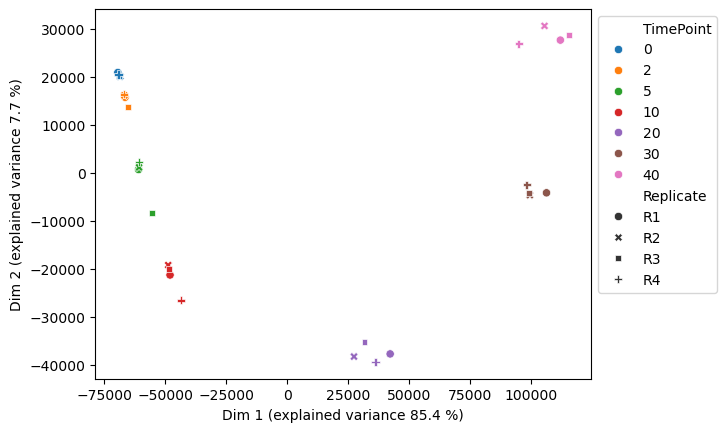

In [21]:
txPCA(tpms[columnOrder])

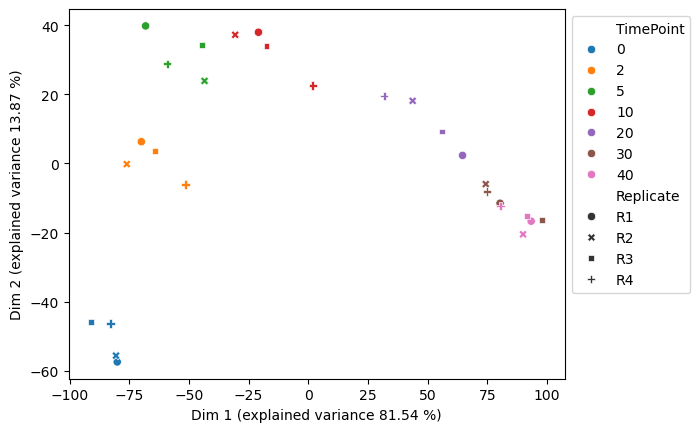

In [22]:
txPCA(logs[columnOrder])

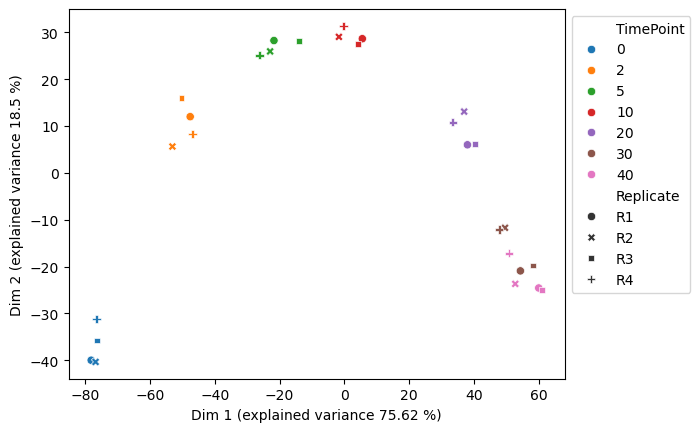

In [23]:
txPCA(logTPMs[columnOrder])

In [24]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

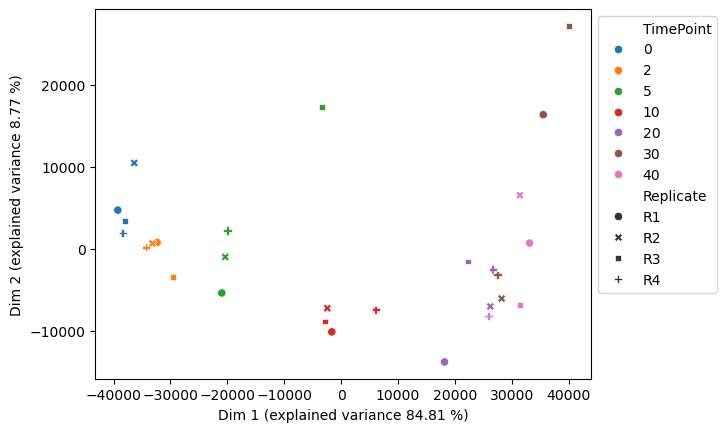

In [25]:
txPCA(tpmHost[columnOrder])

tpmPhage

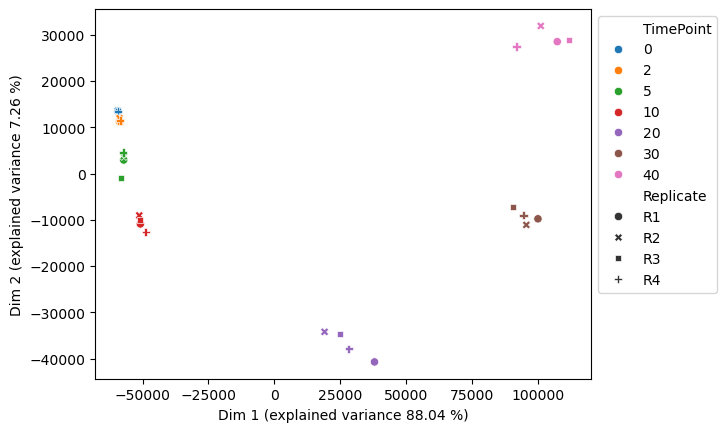

In [26]:
txPCA(tpmPhage[columnOrder])

logTPM Host

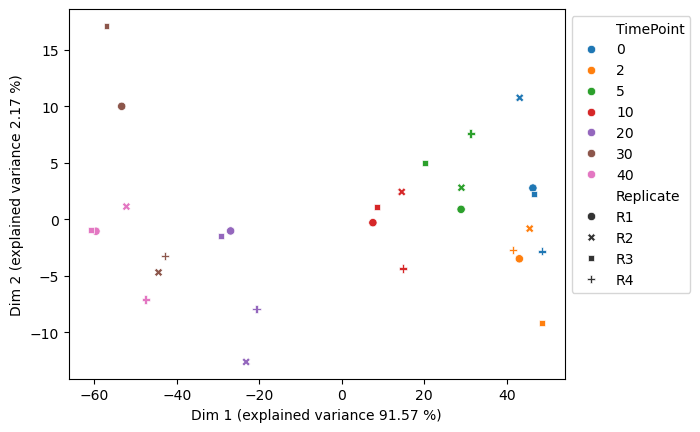

In [27]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

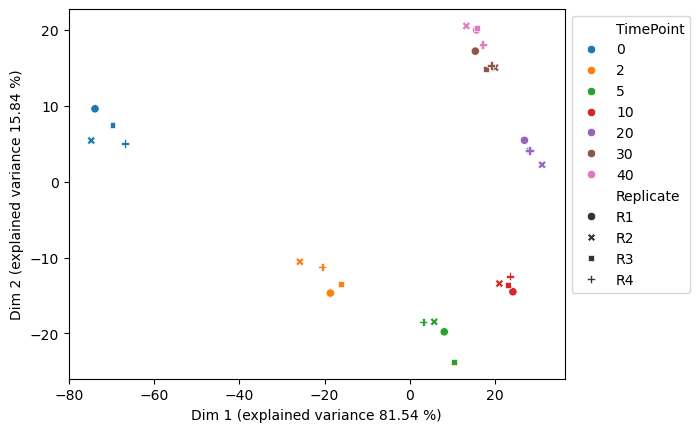

In [28]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Looks wonderfull <3

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [29]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '2', '5', '10', '20', '30', '40']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_1012,497.803558,458.987687,398.415544,320.379179,182.316954,144.373117,117.634755,host,gene-NRS_1012
gene-NRS_44,3.923819,4.986238,2.982496,2.904470,1.945695,0.999984,1.145544,host,gene-NRS_44
gene-NRS_2528,9.649031,8.875540,7.004940,6.050406,3.652092,3.290306,2.862283,host,gene-NRS_2528
gene-NRS_436,150.258824,123.332510,134.070342,89.951641,47.188421,45.310980,30.794138,host,gene-NRS_436
gene-NRS_219,9.031409,8.795165,7.258409,6.176173,3.350329,1.772289,1.644575,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,90.474465,78.225877,67.300144,48.946125,28.278491,21.424687,18.608452,host,gene-NRS_2260
gene-NRS_2493,63.655935,73.034371,62.033545,69.191365,60.558343,43.493433,54.011087,host,gene-NRS_2493
gene-CPT_phageK_gp199,9.776093,131.806378,393.098284,1739.014052,6154.715411,3155.767450,2204.749384,phage,gene-CPT_phageK_gp199


In [30]:
TPMsds = TPMsds[['0', '2', '5', '10', '20', '30', '40']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_1012,9.280501,26.691703,77.837039,33.451676,19.334896,7.585280,11.281199,host,gene-NRS_1012
gene-NRS_44,0.569850,0.411037,0.384643,0.439647,0.400981,0.262089,0.259122,host,gene-NRS_44
gene-NRS_2528,0.489210,0.380256,1.153667,0.861329,0.376272,0.287975,0.168008,host,gene-NRS_2528
gene-NRS_436,15.970266,12.394753,17.235721,12.635193,4.446707,7.139504,1.284461,host,gene-NRS_436
gene-NRS_219,0.349344,0.507514,1.029127,0.690242,0.408803,0.178224,0.150973,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,1.014295,3.059733,2.783897,5.392291,3.427056,1.370191,2.619838,host,gene-NRS_2260
gene-NRS_2493,9.952226,7.650318,5.271001,20.047094,10.759072,9.118345,7.382449,host,gene-NRS_2493
gene-CPT_phageK_gp199,2.238068,24.472286,61.246472,165.032936,318.280740,727.107374,216.775108,phage,gene-CPT_phageK_gp199


In [31]:
propExp = proportionalExp(TPMmeans[['0', '2', '5', '10', '20', '30', '40']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_1012,1.000000,0.922026,0.800347,0.643586,0.366243,0.290020,0.236308,host,gene-NRS_1012
gene-NRS_44,0.786930,1.000000,0.598146,0.582497,0.390213,0.200549,0.229741,host,gene-NRS_44
gene-NRS_2528,1.000000,0.919837,0.725973,0.627048,0.378493,0.340999,0.296639,host,gene-NRS_2528
gene-NRS_436,1.000000,0.820800,0.892263,0.598645,0.314048,0.301553,0.204941,host,gene-NRS_436
gene-NRS_219,1.000000,0.973842,0.803685,0.683855,0.370964,0.196236,0.182095,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,1.000000,0.864618,0.743858,0.540994,0.312558,0.236804,0.205676,host,gene-NRS_2260
gene-NRS_2493,0.871589,1.000000,0.849375,0.947381,0.829176,0.595520,0.739530,host,gene-NRS_2493
gene-CPT_phageK_gp199,0.001588,0.021416,0.063869,0.282550,1.000000,0.512740,0.358221,phage,gene-CPT_phageK_gp199


## 5. Phage gene classification

In [32]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('middle')
        elif timePoint == 5:
            labels.append('late')
        elif timePoint == 6:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [34]:
TPMmeans

,0,2,5,10,20,30,40,Entity,Symbol
Geneid,,,,,,,,,
gene-NRS_1012,497.803558,458.987687,398.415544,320.379179,182.316954,144.373117,117.634755,host,gene-NRS_1012
gene-NRS_44,3.923819,4.986238,2.982496,2.904470,1.945695,0.999984,1.145544,host,gene-NRS_44
gene-NRS_2528,9.649031,8.875540,7.004940,6.050406,3.652092,3.290306,2.862283,host,gene-NRS_2528
gene-NRS_436,150.258824,123.332510,134.070342,89.951641,47.188421,45.310980,30.794138,host,gene-NRS_436
gene-NRS_219,9.031409,8.795165,7.258409,6.176173,3.350329,1.772289,1.644575,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,90.474465,78.225877,67.300144,48.946125,28.278491,21.424687,18.608452,host,gene-NRS_2260
gene-NRS_2493,63.655935,73.034371,62.033545,69.191365,60.558343,43.493433,54.011087,host,gene-NRS_2493
gene-CPT_phageK_gp199,9.776093,131.806378,393.098284,1739.014052,6154.715411,3155.767450,2204.749384,phage,gene-CPT_phageK_gp199


In [35]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [36]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
middle    145
early      52
late       40
Name: count, dtype: int64

Add classes to other dfs.

In [37]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'CP027476.1']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_005880.2']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [38]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [39]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_1012,486.550933,510.748168,501.902000,492.013131,421.050474,491.978932,449.012735,473.908607,413.627041,437.105997,268.864940,474.064199,274.314713,355.350444,302.799985,349.051573,211.083137,161.089447,168.830703,188.264527,134.279561,142.103873,155.386553,145.722480,110.118751,128.201733,103.142846,129.075692,host,gene-NRS_1012,None,None,72.790125
gene-NRS_44,3.648661,3.127485,4.372949,4.546184,4.962879,4.435174,5.594860,4.952039,3.220242,3.458790,2.789030,2.461925,3.309400,2.396367,2.540304,3.371808,1.309807,2.363556,1.912557,2.196860,0.943201,1.273490,0.597303,1.185943,1.184774,0.951824,0.892959,1.552621,host,gene-NRS_44,None,None,0.733425
gene-NRS_2528,10.371580,9.451272,9.027180,9.746094,8.626668,9.522190,8.774560,8.578743,7.659937,6.994320,5.151896,8.213609,5.159796,6.484305,5.308761,7.248763,4.228640,3.458079,3.212725,3.708926,2.938829,3.587435,3.074149,3.560810,2.993767,2.763053,2.639695,3.052617,host,gene-NRS_2528,None,None,1.158701
gene-NRS_436,147.030017,176.642696,143.455456,133.907129,112.980688,130.958606,109.770775,139.619970,118.909919,127.271913,126.731369,163.368169,78.688638,104.232414,76.129283,100.756229,50.535215,43.911622,41.807774,52.499072,48.893407,39.587115,55.213483,37.549916,30.228156,32.182648,31.799346,28.966401,host,gene-NRS_436,None,None,24.070654
gene-NRS_219,9.209711,8.426982,9.255649,9.233295,8.643119,9.588579,8.767724,8.181237,7.586266,8.026254,5.498318,7.922797,5.454201,6.332406,5.684429,7.233655,3.552244,3.115147,2.832245,3.901681,1.515418,1.698056,1.918517,1.957165,1.681776,1.425286,1.847694,1.623545,host,gene-NRS_219,None,None,1.639946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,91.854880,90.669444,89.004609,90.368926,77.639598,82.969566,74.420975,77.873369,65.714485,66.734138,64.780784,71.971169,44.756991,51.970536,42.860166,56.196808,26.231755,28.374543,24.732886,33.774779,20.161690,20.105638,22.067185,23.364234,17.930348,18.438182,15.385345,22.679933,host,gene-NRS_2260,None,None,14.367044
gene-NRS_2493,68.230934,49.619510,60.217311,76.555983,65.769844,71.430611,85.818389,69.118641,62.685005,59.516574,55.802705,70.129897,55.414861,66.040206,52.510126,102.800267,57.133750,66.618095,44.903574,73.577954,35.632147,50.665210,33.371456,54.304921,49.694717,53.404472,46.806006,66.139153,host,gene-NRS_2493,None,None,3.324264
gene-CPT_phageK_gp199,10.203560,6.011581,11.206313,11.682917,114.602915,103.340564,165.742096,143.539936,472.485005,427.521543,313.379337,359.007250,1596.843165,1631.390371,1712.337265,2015.485408,5725.872349,6047.820053,6240.417525,6604.751716,2736.250310,3725.951810,2185.368089,3975.499590,2035.117663,2411.756771,1945.603301,2426.519803,phage,gene-CPT_phageK_gp199,middle,middle,2135.261991


In [40]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [41]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,0_R1,0_R2,0_R3,0_R4,2_R1,2_R2,2_R3,2_R4,5_R1,5_R2,5_R3,5_R4,10_R1,10_R2,10_R3,10_R4,20_R1,20_R2,20_R3,20_R4,30_R1,30_R2,30_R3,30_R4,40_R1,40_R2,40_R3,40_R4,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
gene-NRS_1012,43054,47775,53168,44422,38920,47773,35104,33907,51712,37112,26469,48763,24807,33222,25634,19356,9320,9146,8872,12270,7274,7205,6865,7106,5375,5823,5253,6208,host,gene-NRS_1012
gene-NRS_44,287,260,412,365,408,383,389,315,358,261,244,225,266,199,191,166,51,119,89,127,45,57,23,51,51,38,40,66,host,gene-NRS_44
gene-NRS_2528,1334,1285,1390,1279,1159,1344,997,892,1392,863,737,1228,678,881,653,584,271,285,245,351,231,264,197,252,212,182,195,213,host,gene-NRS_2528
gene-NRS_436,11378,14450,13290,10573,9133,11121,7505,8736,13001,9450,10911,14696,6223,8522,5636,4886,1951,2180,1921,2992,2316,1755,2133,1601,1290,1278,1416,1218,host,gene-NRS_436
gene-NRS_219,610,590,734,624,598,697,513,438,710,510,405,610,369,443,360,300,117,132,111,190,61,64,63,71,61,48,70,58,host,gene-NRS_219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-NRS_2260,6031,6293,6996,6054,5325,5978,4317,4134,6096,4204,4732,5493,3003,3605,2692,2312,859,1195,964,1633,810,756,723,845,649,621,581,809,host,gene-NRS_2260
gene-NRS_2493,2741,2107,2896,3138,2760,3149,3046,2245,3558,2294,2494,3275,2275,2803,2018,2588,1145,1717,1071,2177,876,1166,669,1202,1101,1101,1082,1444,host,gene-NRS_2493
gene-CPT_phageK_gp199,368,229,484,430,4323,4095,5288,4191,24108,14814,12591,15071,58937,62248,59163,45615,103186,140146,133845,175689,60498,77106,39407,79125,40545,44711,40444,47634,phage,gene-CPT_phageK_gp199


In [42]:
# Full TPM table
tpms.to_csv('Kongari_WT_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Kongari_WT_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Kongari_WT_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Kongari_WT_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Kongari_WT_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Kongari_WT_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Kongari_WT_phage_gff3.tsv', sep='\t')